In [1]:
import sys
print(f'This notebook was last run with this kernel {sys.executable}')

This notebook was last run with this kernel /home/igarzonalva/.conda/envs/scvi_cpu_env/bin/python


In [2]:
import warnings 

import scanpy as sc
import os
import numpy as np
import pandas as pd
import scvi

import matplotlib.pyplot as plt
os.chdir('/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/02_Integration')

/home/igarzonalva/.conda/envs/scvi_cpu_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load adata and scanvi model 

In [3]:
adata = sc.read_h5ad("./adata/adata_scanvi_cuda.h5ad")
adata

AnnData object with n_obs × n_vars = 205006 × 22788
    obs: 'batch', 'subtype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'complexity', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting', 'doublet_score', 'predicted_doublet', 'leiden', 'IGA_First_GenAnno'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'IGA_First_GenAnno_colors', 'batch_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'majority_voting_colors', 'neighbors', 'predicted_labels_colors', 'subtype_colors', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [4]:
adata_hvg = adata[:, adata.var.highly_variable].copy()

In [5]:
model = scvi.model.SCANVI.load("./models/scanvi_model_cuda", adata_hvg)

INFO     File ./models/scanvi_model_cuda/model.pt already downloaded                                               


/home/igarzonalva/.conda/envs/scvi_cpu_env/lib/python3.12/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/igarzonalva/.conda/envs/scvi_cpu_env/lib/python3.12/site-packages/torch/cuda/__init__.py:905: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  r = torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count
/home/igarzonalva/.conda/envs/scvi_cpu_env/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightn

In [7]:
predictions = model.predict(soft = True)

In [8]:
max_probs = predictions.max(axis=1)
assigned_ct = predictions.idxmax(axis=1)

In [9]:
cell_type_predictions = pd.DataFrame(data={'prediction':assigned_ct.values,'probability': max_probs.values}, 
                 index= assigned_ct.index)

In [10]:
cell_type_predictions

,prediction,probability
AAACCTGCAAGCGTAG-1-GSM4909281,T cells,0.999997
AAACCTGCAATAGAGT-1-GSM4909281,Cycling Epithelial,0.995859
AAACCTGCAATTGCTG-1-GSM4909281,Cycling Epithelial,0.975586
AAACCTGCACTCAGGC-1-GSM4909281,Epithelial,0.999963
AAACCTGCAGTGACAG-1-GSM4909281,Endothelial,1.000000
...,...,...
TTTGTTGGTGGGTATG-1-GSM4909317,Epithelial,0.999999
TTTGTTGTCACTTTGT-1-GSM4909317,Epithelial,0.600955
TTTGTTGTCGCACGGT-1-GSM4909317,T cells,0.999999
TTTGTTGTCTCCCTAG-1-GSM4909317,B cells,0.856971


# Review SCANVI predictions 

## Histogram of scanvi predictions score

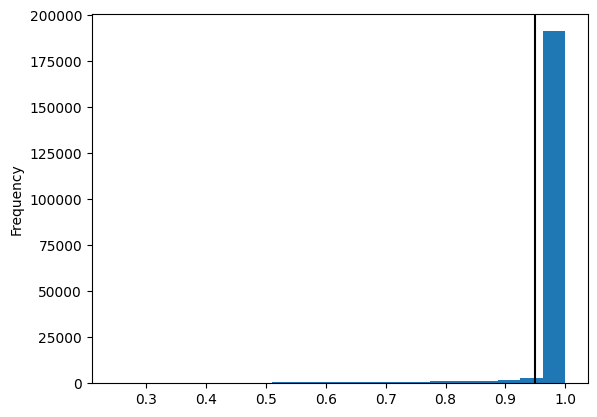

In [12]:
cell_type_predictions.probability.plot.hist(bins = 20)
plt.axvline(x=0.95,color='k')

In [13]:
cell_type_predictions['labels_refined'] = np.where(
    cell_type_predictions['probability'] < 0.95,    
    'unknown',
    cell_type_predictions['prediction']
)
cell_type_predictions

,prediction,probability,labels_refined
AAACCTGCAAGCGTAG-1-GSM4909281,T cells,0.999997,T cells
AAACCTGCAATAGAGT-1-GSM4909281,Cycling Epithelial,0.995859,Cycling Epithelial
AAACCTGCAATTGCTG-1-GSM4909281,Cycling Epithelial,0.975586,Cycling Epithelial
AAACCTGCACTCAGGC-1-GSM4909281,Epithelial,0.999963,Epithelial
AAACCTGCAGTGACAG-1-GSM4909281,Endothelial,1.000000,Endothelial
...,...,...,...
TTTGTTGGTGGGTATG-1-GSM4909317,Epithelial,0.999999,Epithelial
TTTGTTGTCACTTTGT-1-GSM4909317,Epithelial,0.600955,unknown
TTTGTTGTCGCACGGT-1-GSM4909317,T cells,0.999999,T cells
TTTGTTGTCTCCCTAG-1-GSM4909317,B cells,0.856971,unknown


## Transfer predictions into adata

In [14]:
adata = adata[cell_type_predictions.index.values,:].copy()
adata.obs['scanvi_prediction'] = cell_type_predictions.labels_refined
adata.obs['scanvi_prediction'] = adata.obs['scanvi_prediction'].astype("category")
adata.obs["scanvi_prediction"].value_counts()

scanvi_prediction
Epithelial            76207
T cells               40428
Cycling Epithelial    20523
Myeloid               18810
unknown               12629
Fibroblast FAP+       11088
Plasma cells           7468
B cells                6648
Endothelial            4947
Fibroblast FAP-        4242
Mast cells             2016
Name: count, dtype: int64

## Visualize predictions

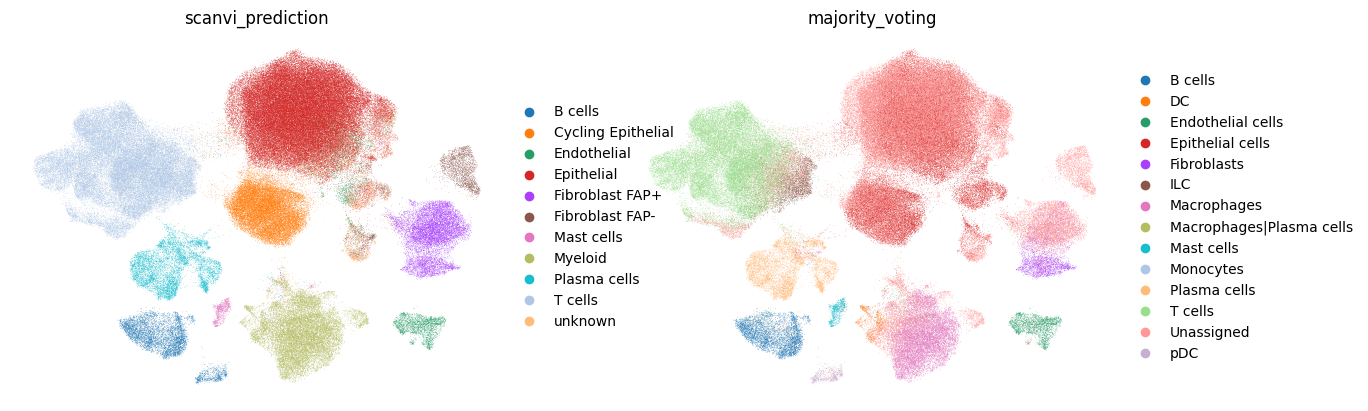

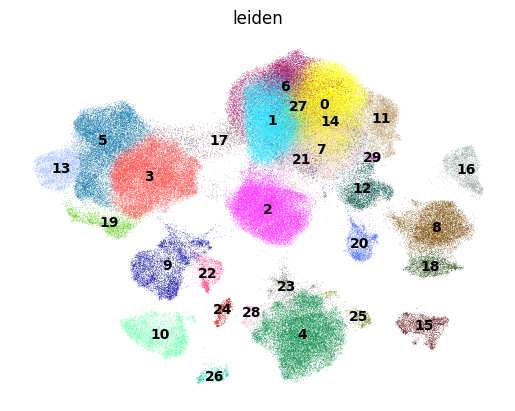

In [15]:
sc.pl.umap(
    adata,    
    color=["scanvi_prediction",'majority_voting'],
    frameon=False, #legend_loc="on data", 
    ncols=2,)

sc.pl.umap(
    adata,    
    color=['leiden'],
    frameon=False, legend_loc="on data", 
    ncols=1)

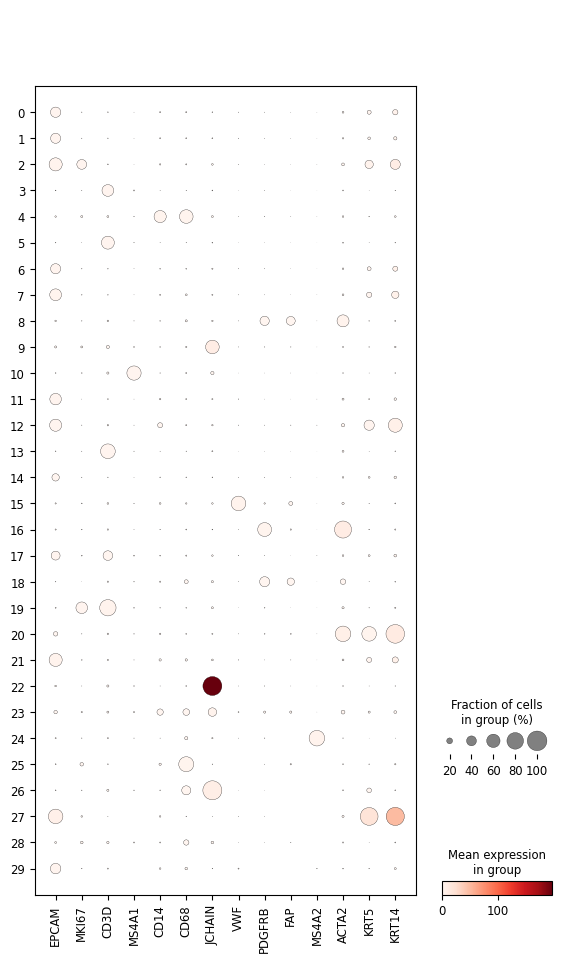

In [16]:
general_markers  = ["EPCAM","MKI67", "CD3D", "MS4A1", "CD14", "CD68","JCHAIN", "VWF", "PDGFRB","FAP","MS4A2","ACTA2", "KRT5", "KRT14"]
sc.pl.dotplot(adata=adata, var_names=general_markers, groupby=["leiden"])

# Check leiden cluster 17 as it appears to express T and Epithelial markers at the same time 

In [18]:
leiden17 = adata[adata.obs.leiden == "17",:].copy()
leiden17_counts = pd.DataFrame({"values":leiden17.obs.doublet_score.values, "cells":leiden17.obs.n_genes_by_counts.index })
adata_score = pd.DataFrame({"values":adata.obs.doublet_score.values, "cells":adata.obs.n_genes_by_counts.index })
leiden17.n_obs

2275

<Axes: ylabel='Frequency'>

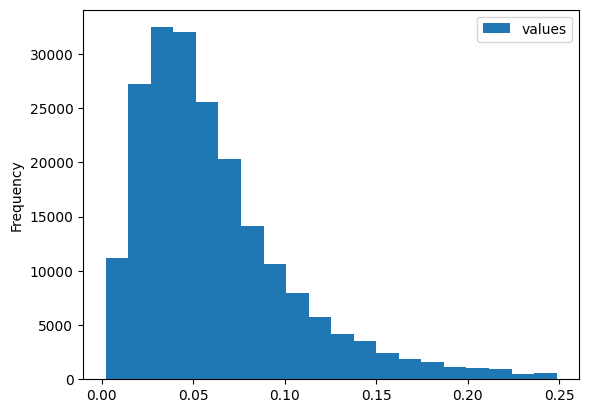

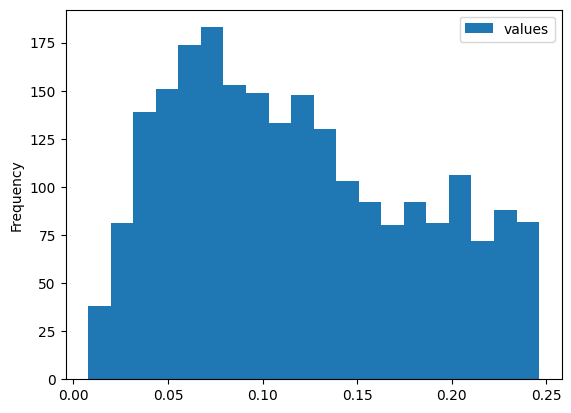

In [19]:
adata_score.plot.hist(bins = 20)
leiden17_counts.plot.hist(bins = 20)

Due to high chance of it being doublets, it is removed

In [20]:
mask = adata.obs.leiden != '17'
adata = adata[mask,:].copy()

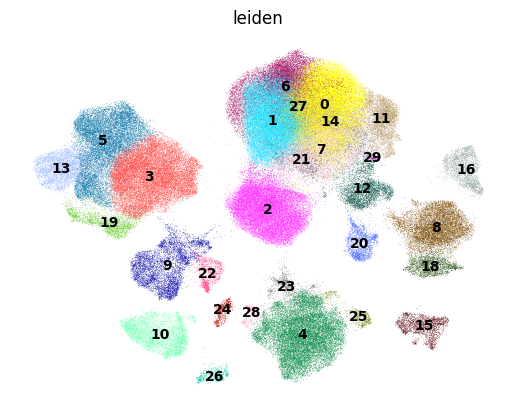

In [21]:
sc.pl.umap(
    adata,    
    color=['leiden'],
    frameon=False, legend_loc="on data", 
    ncols=1)

# Check Population associated with leiden cluster 20

EPCAM-, KRT8-, KRT18- 
KRT5+ KRT14+ ACTA2+ KRT17+ TAGLN +
FAP- PDGFR- 

They are possible a Basal cells

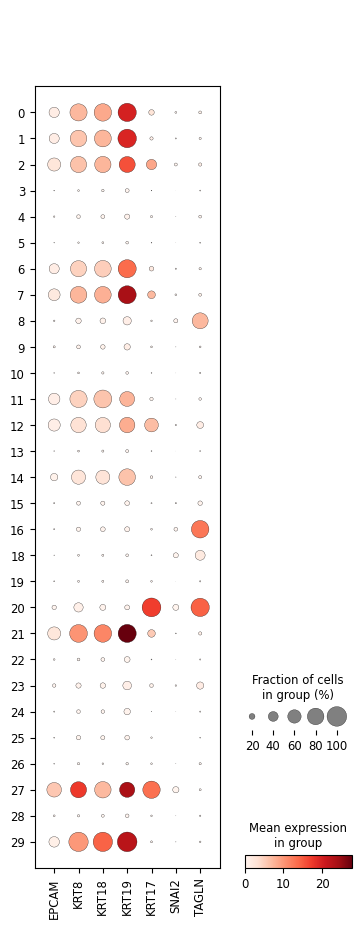

In [22]:
epi_markers  = ["EPCAM","KRT8", "KRT18", "KRT19", "KRT17", "SNAI2","TAGLN"]
sc.pl.dotplot(adata=adata, var_names=epi_markers, groupby=["leiden"])

# Rename based on leiden clustering to eliminate ambiguos annotation

In [24]:
rename_map = {
    '0': 'Epithelial',
    '1': 'Epithelial',
    '6': 'Epithelial',
    '7': 'Epithelial',
    '11': 'Epithelial',
    '12': 'Epithelial',
    '14': 'Epithelial',
    '21': 'Epithelial',
    '27': 'Epithelial',
    '29': 'Epithelial',
    '20': 'Myoepithelial cells',
    '3': 'T cells',
    '5': 'T cells',
    '13': 'T cells',
    '19': 'T cells',
    '9': 'Plasma cells',
    '22': 'Plasma cells',
    '10': 'B cells',
    '26': 'B cells',
    '24': 'Mast cells',
    '15': 'Endothelial',
    '8': 'Fibroblast FAP+',
    '18': 'Fibroblast FAP+',
    '16': 'Fibroblast FAP-',
    '2': 'Cycling Epithelial',
    '28': 'Myeloid',
    '23': 'Myeloid',
    '25': 'Myeloid',
    '4': 'Myeloid'
}

In [25]:
len(rename_map)

29

In [26]:
adata.obs['IGA_PostScAnvi_GenAnno_colors'] = adata.obs.leiden.astype(str).replace(rename_map).astype('category')

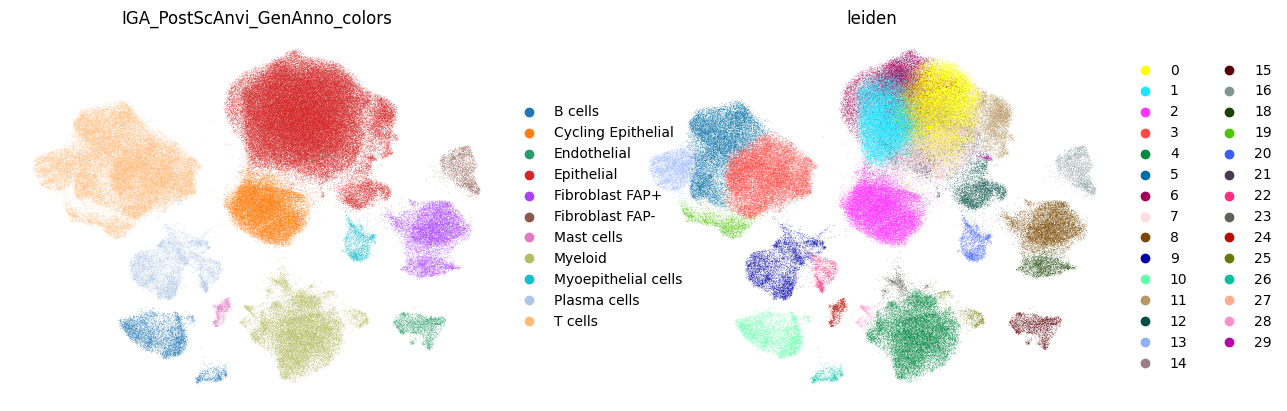

In [28]:
sc.pl.umap(
    adata,    
    color=['IGA_PostScAnvi_GenAnno_colors','leiden'],
    frameon=False, 
    ncols=2)

In [36]:
adata.write_h5ad('./adata/GenAnnoPostScvi.h5ad')

# Send to SCANVI to refine

In [20]:
adata = sc.read_h5ad("./adata/adata_scanvi_cuda_refinement.h5ad")

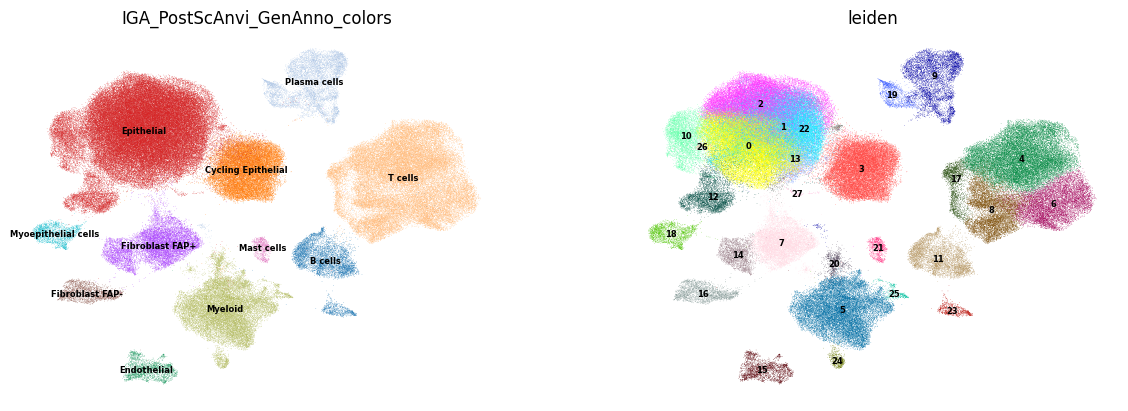

In [17]:
sc.pl.umap(
    adata,
    color=["IGA_PostScAnvi_GenAnno_colors","leiden"],
    frameon=False, legend_loc="on data", legend_fontsize = 6,
    ncols=2)

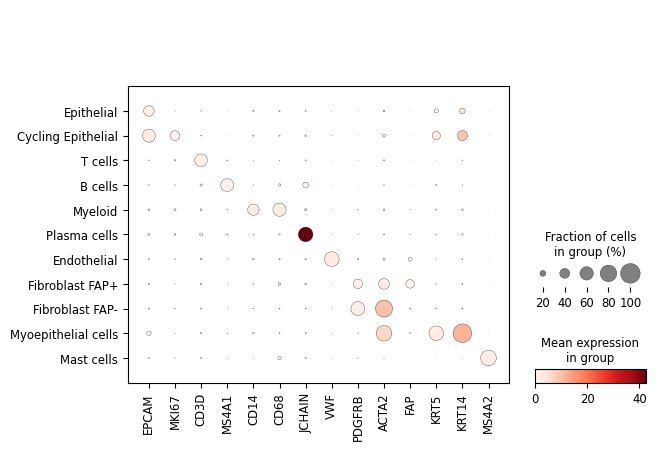

In [23]:
general_markers  = ["EPCAM","MKI67", "CD3D", "MS4A1", "CD14", "CD68","JCHAIN", "VWF", "PDGFRB","ACTA2","FAP", "KRT5", "KRT14","MS4A2"]


cell_type_order = ['Epithelial', 'Cycling Epithelial','T cells', 'B cells', 'Myeloid','Plasma cells', 'Endothelial', 'Fibroblast FAP+', 
                  'Fibroblast FAP-', 'Myoepithelial cells','Mast cells']

adata.obs["IGA_PostScAnvi_GenAnno_colors"] = pd.Categorical(
    adata.obs["IGA_PostScAnvi_GenAnno_colors"],
    categories=cell_type_order,
    ordered=True
)

sc.pl.dotplot(adata=adata, var_names=general_markers, groupby=["IGA_PostScAnvi_GenAnno_colors"])

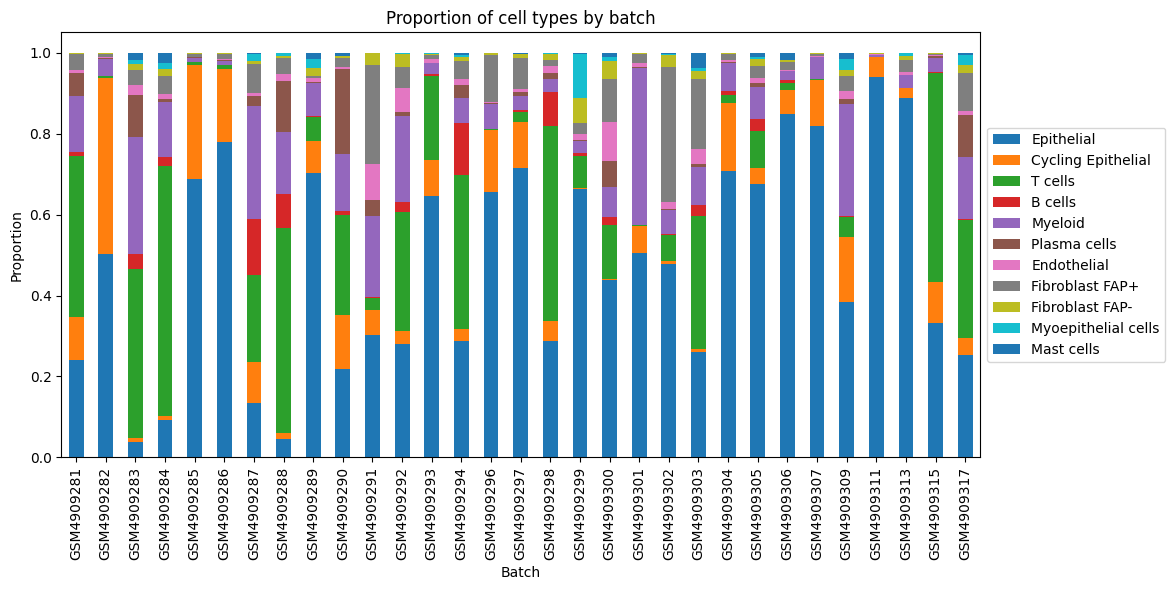

In [114]:
df_counts = (
    adata.obs
    .groupby(['batch', 'IGA_PostScAnvi_GenAnno_colors'], observed=True)
    .size()                       
    .unstack(fill_value=0)       
)
df_proportions = df_counts.div(df_counts.sum(axis=1), axis=0)
ax = df_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

ax.set_xlabel('Batch')
ax.set_ylabel('Proportion')
ax.set_title('Proportion of cell types by batch')
plt.tight_layout()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

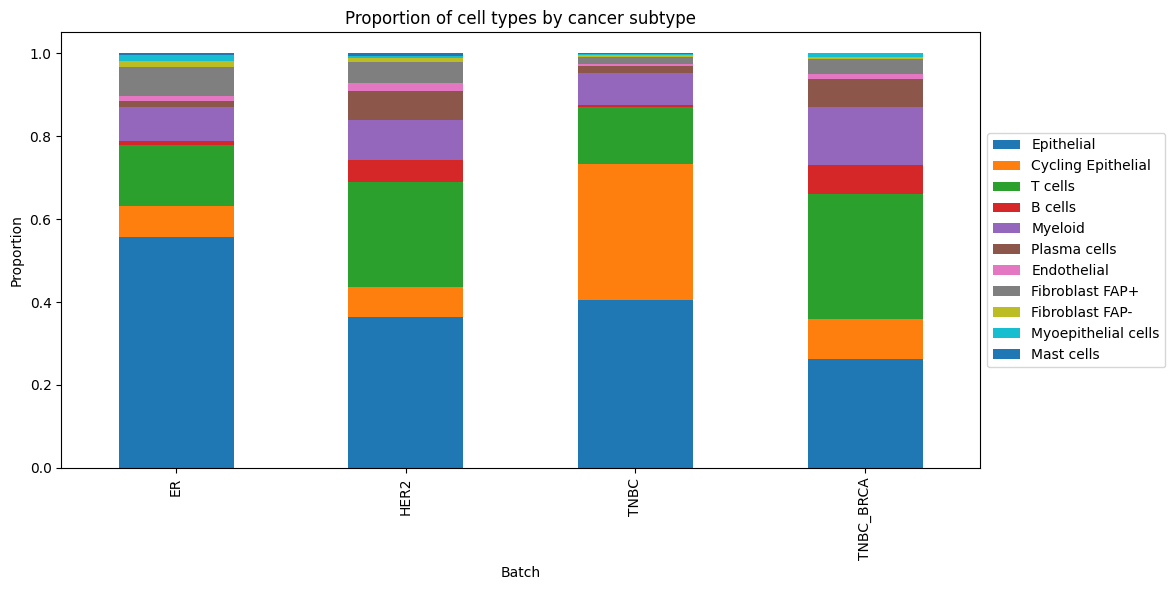

In [117]:
df_counts = adata.obs.groupby(['subtype', 'IGA_PostScAnvi_GenAnno_colors'], observed=True).size().unstack(fill_value=0)       
df_proportions = df_counts.div(df_counts.sum(axis=1), axis=0)
ax = df_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

ax.set_xlabel('Batch')
ax.set_ylabel('Proportion')
ax.set_title('Proportion of cell types by cancer subtype')
plt.tight_layout()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [121]:
adata.obs.IGA_PostScAnvi_GenAnno_colors.value_counts()

IGA_PostScAnvi_GenAnno_colors
Epithelial             90418
T cells                39903
Cycling Epithelial     20964
Myeloid                19409
Fibroblast FAP+        11062
Plasma cells            7402
B cells                 6053
Endothelial             2397
Fibroblast FAP-         2278
Myoepithelial cells     1992
Mast cells               853
Name: count, dtype: int64